In [1]:
# Welcome to the SceneFake database. 

# Here is a description of training, development, and evaluation data.

# 1. train, dev and eval directories contain audio files used for training, development and evaluation (A_*.wav, B_*.wav and C_*.wav, respectively). The waveforms in the directories are in the standard RIFF/WAVE format. The sampling rate is 16 kHz, and stored in 16-bit format.

# % database_path/
#     %   |- train
#     %      |- real
#     %      |- fake
#     %   |- dev
#     %      |- real
#     %      |- fake
#     %   |- eval
#     %      |- real
#     %      |- fake
#     %   |- README.txt

# 2. The information contained in the name of the audio file is as follows.

# A_123_0_A.wav 

# The first letter represents whether it is a training set, validation set, or testing set. 
# % [A: train, B: dev, C: eval]

# The '123' refers to the serial number of the audio.

# The second number represents the signal / noise ratio.
# %[0:SNR=0, 05:SNR=-5, 5:SNR=5, 10:SNR=10, 15:SNR=15, 20:SNR=20]

# The last letter represents the way of noise reduction.
# % [A: fullsubnet, B: mmse, C: spec, D: wiener]



In [2]:
import os
import random
import sys


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio, display
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow
py.init_notebook_mode(connected=True)


## Keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3
# % pylab inline

In [3]:
sns.set(style="whitegrid")

In [4]:
BASE_DIR = r"C://Users//sruja//Deepfake//deepfake"

In [5]:
# -----------------------
# COUNT REAL / FAKE FILES
# -----------------------
def count_files(path):
    real = len(os.listdir(os.path.join(path, "real")))
    fake = len(os.listdir(os.path.join(path, "fake")))
    return real, fake


In [6]:
train_real, train_fake = count_files(os.path.join(BASE_DIR, "train"))
dev_real, dev_fake     = count_files(os.path.join(BASE_DIR, "dev"))
eval_real, eval_fake   = count_files(os.path.join(BASE_DIR, "eval"))

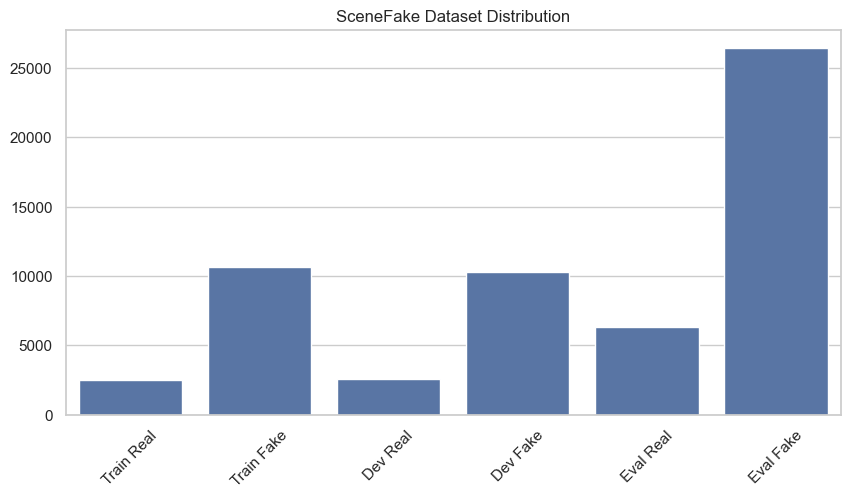

In [7]:
# Plot counts
plt.figure(figsize=(10,5))
labels = ["Train Real", "Train Fake", "Dev Real", "Dev Fake", "Eval Real", "Eval Fake"]
values = [train_real, train_fake, dev_real, dev_fake, eval_real, eval_fake]
sns.barplot(x=labels, y=values)
plt.title("SceneFake Dataset Distribution")
plt.xticks(rotation=45)
plt.show()


In [8]:
sample_file = os.path.join(BASE_DIR, "train", "fake", os.listdir(os.path.join(BASE_DIR, "train","fake"))[0])

print("Selected File:", sample_file)

Selected File: C://Users//sruja//Deepfake//deepfake\train\fake\A_10000_5_C.wav


In [9]:
audio, sr = librosa.load(sample_file, sr=16000)


In [10]:
display(Audio(audio, rate=sr))

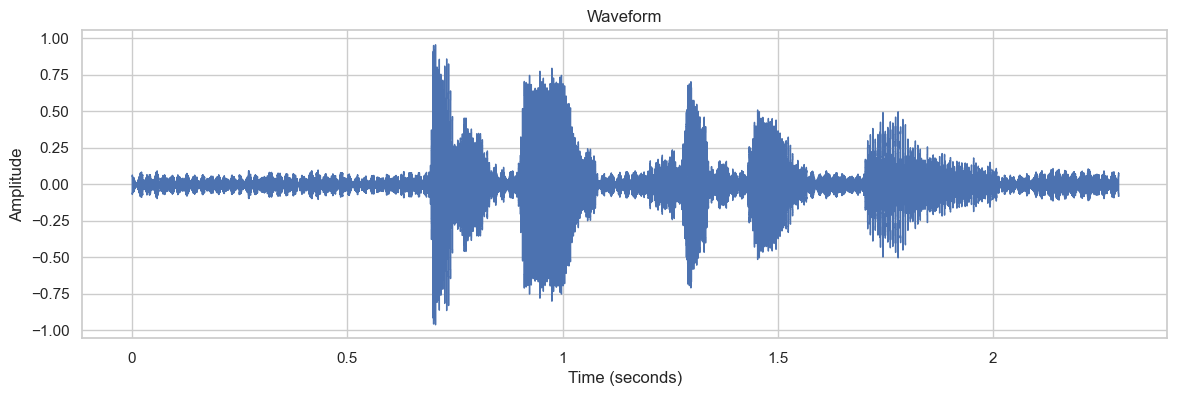

In [11]:
# -----------------------
# PLOT WAVEFORM
# -----------------------
plt.figure(figsize=(14,4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.show()



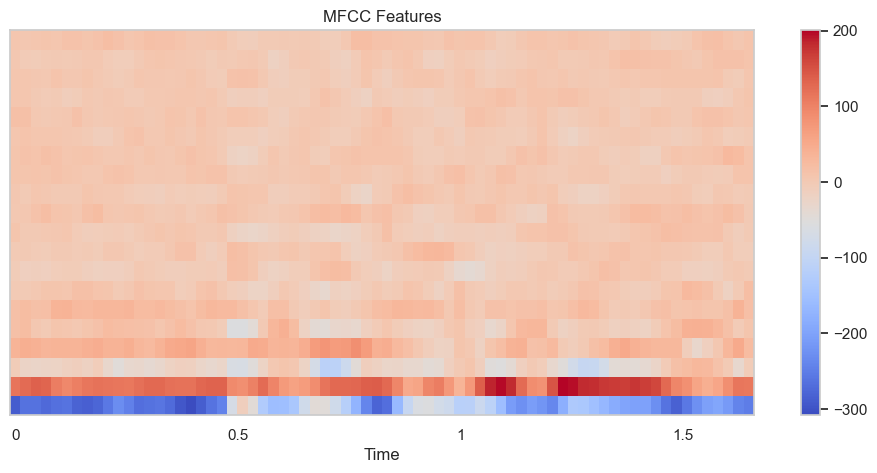

In [12]:
# -----------------------
# MFCC FEATURES
# -----------------------
mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)

plt.figure(figsize=(12,5))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title("MFCC Features")
plt.show()

In [13]:
def load_audio(path):
    audio, sr = librosa.load(path, sr=16000)
    return audio, sr


In [14]:
def plot_spectrogram(audio, sr, title="Spectrogram"):
    stft = librosa.stft(audio)
    spect = librosa.amplitude_to_db(abs(stft))

    plt.figure(figsize=(12,4))
    librosa.display.specshow(spect, sr=sr, x_axis='time', y_axis='log')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


In [15]:
def plot_melspectrogram(audio, sr, title="Mel-Spectrogram"):
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=64)
    mel_db = librosa.amplitude_to_db(mel, ref=np.max)

    plt.figure(figsize=(12,4))
    librosa.display.specshow(mel_db, sr=sr, x_axis='time')
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.show()


In [16]:
def plot_mfcc_features(audio, sr, title="MFCC"):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    delta = librosa.feature.delta(mfcc)

    fig, ax = plt.subplots(2, 1, figsize=(12,7))

    librosa.display.specshow(mfcc, x_axis='time', ax=ax[0])
    ax[0].set_title("MFCC")

    librosa.display.specshow(delta, x_axis='time', ax=ax[1])
    ax[1].set_title("Delta MFCC")

    plt.tight_layout()
    plt.show()


In [17]:
def compare_real_fake(real_path, fake_path):
    real_audio, sr = load_audio(real_path)
    fake_audio, sr = load_audio(fake_path)

    fig, axes = plt.subplots(4, 2, figsize=(14,14))
    titles = ["Waveform", "Spectrogram", "Mel-Spectrogram", "MFCC"]

    # --- LEFT: REAL ---
    librosa.display.waveshow(real_audio, sr=sr, ax=axes[0][0])
    axes[0][0].set_title("REAL - Waveform")

    librosa.display.specshow(librosa.amplitude_to_db(abs(librosa.stft(real_audio))), sr=sr, ax=axes[1][0], y_axis='log')
    axes[1][0].set_title("REAL - Spectrogram")

    mel = librosa.feature.melspectrogram(y=real_audio, sr=sr)
    librosa.display.specshow(librosa.amplitude_to_db(mel), sr=sr, ax=axes[2][0])
    axes[2][0].set_title("REAL - Mel Spectrogram")

    mfcc = librosa.feature.mfcc(y=real_audio, sr=sr, n_mfcc=20)
    librosa.display.specshow(mfcc, sr=sr, ax=axes[3][0])
    axes[3][0].set_title("REAL - MFCC")

    # --- RIGHT: FAKE ---
    librosa.display.waveshow(fake_audio, sr=sr, ax=axes[0][1])
    axes[0][1].set_title("FAKE - Waveform")

    librosa.display.specshow(librosa.amplitude_to_db(abs(librosa.stft(fake_audio))), sr=sr, ax=axes[1][1], y_axis='log')
    axes[1][1].set_title("FAKE - Spectrogram")

    mel2 = librosa.feature.melspectrogram(y=fake_audio, sr=sr)
    librosa.display.specshow(librosa.amplitude_to_db(mel2), sr=sr, ax=axes[2][1])
    axes[2][1].set_title("FAKE - Mel Spectrogram")

    mfcc2 = librosa.feature.mfcc(y=fake_audio, sr=sr, n_mfcc=20)
    librosa.display.specshow(mfcc2, sr=sr, ax=axes[3][1])
    axes[3][1].set_title("FAKE - MFCC")

    plt.tight_layout()
    plt.show()


In [18]:
real_example = os.path.join(BASE_DIR, "train", "real", os.listdir(os.path.join(BASE_DIR,"train","real"))[0])
fake_example = os.path.join(BASE_DIR, "train", "fake", os.listdir(os.path.join(BASE_DIR,"train","fake"))[0])

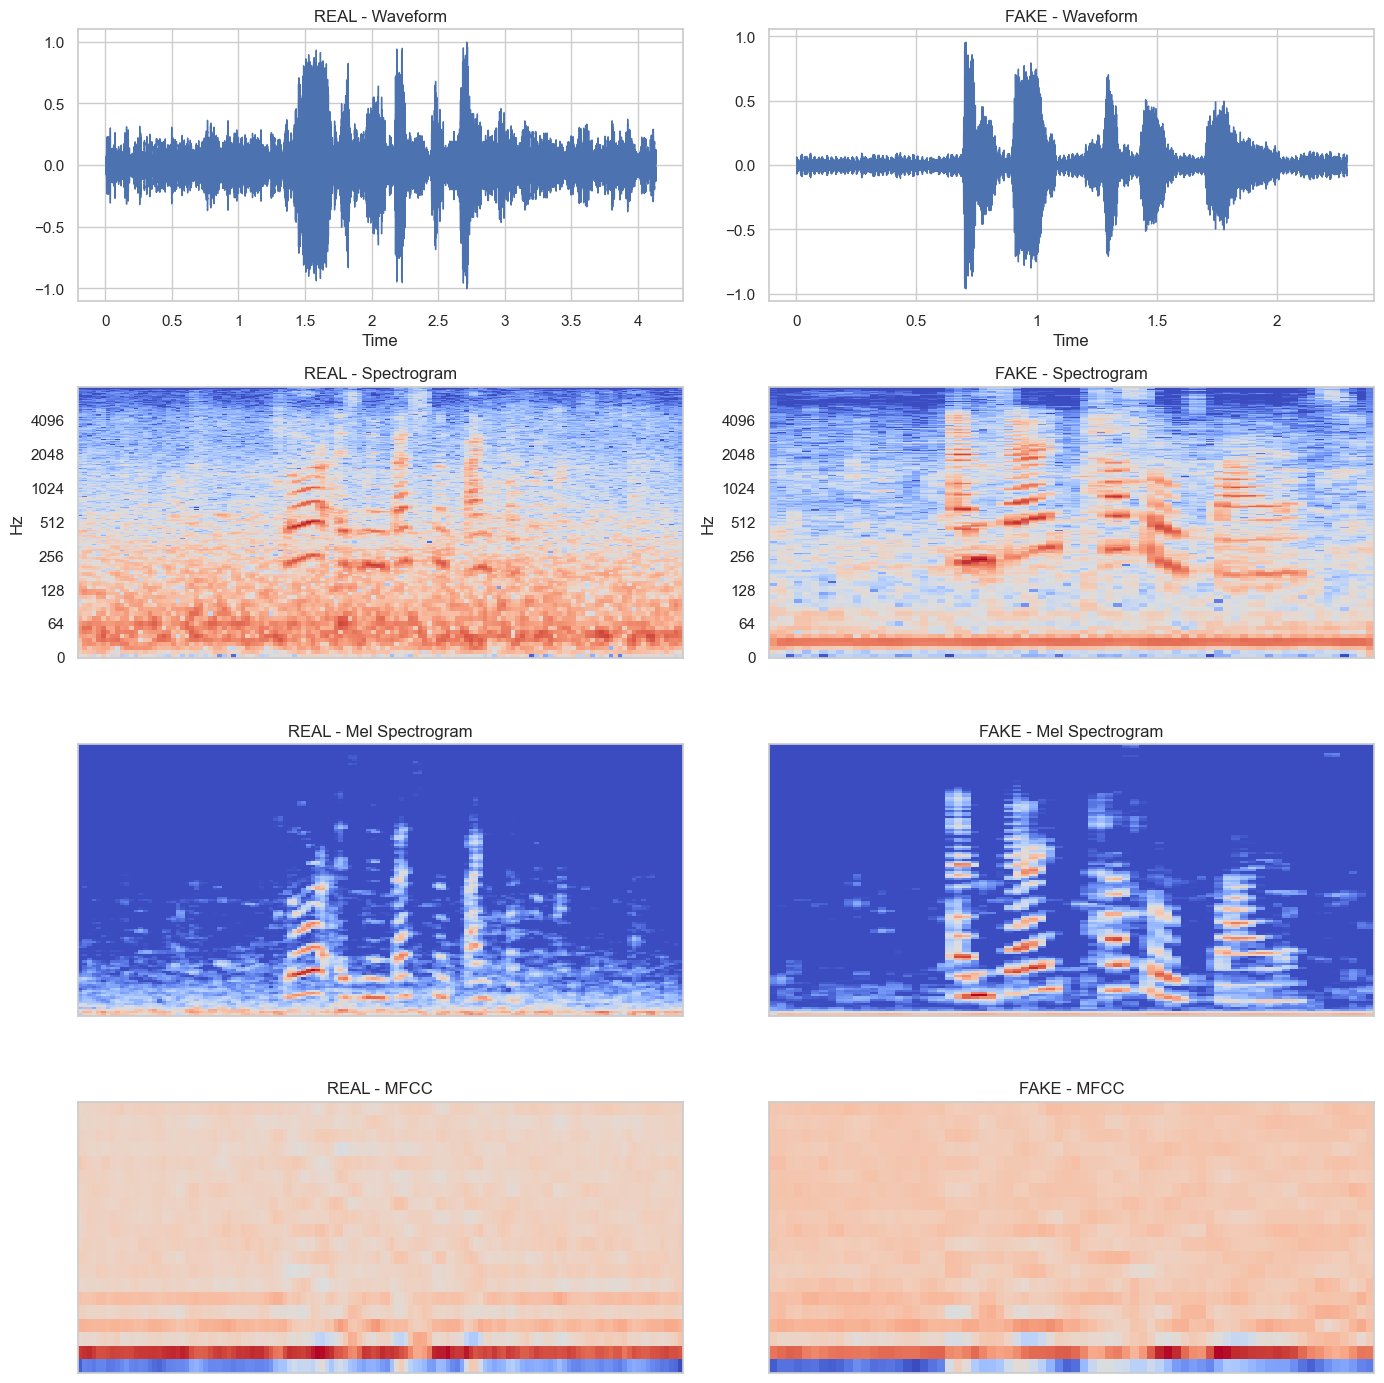

In [19]:
compare_real_fake(real_example, fake_example)


# FEATURE EXTRACTION 

In [20]:
def extract_all_features(file_path):
    audio, sr = librosa.load(file_path, sr=16000)

    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=40).T, axis=0)
    spec = np.mean(librosa.amplitude_to_db(abs(librosa.stft(audio, n_fft=512))).T, axis=0)

    combined = np.concatenate([mfcc, mel, spec])
    return combined


In [21]:
features = []
labels = []

In [22]:
def load_folder(path, label):
    for f in os.listdir(path):
        fp = os.path.join(path, f)
        feat = extract_all_features(fp)
        features.append(feat)
        labels.append(label)

In [23]:
load_folder(os.path.join(BASE_DIR, "train", "real"), "real")
load_folder(os.path.join(BASE_DIR, "train", "fake"), "fake")


In [24]:
df = pd.DataFrame(features)
df['label'] = labels

print(df.head())

            0           1         2          3         4          5         6  \
0 -115.073235  122.886726 -3.855181  35.371086  0.096423  24.082096 -1.501806   
1 -126.982536  116.249992 -5.899298  34.534634 -5.689754  25.322906  0.929477   
2  -78.466942  121.909035 -0.105061  38.046898  1.207443  19.700571 -0.158639   
3 -105.627563  123.313683 -0.531501  31.519543 -3.076708  25.814548 -1.216088   
4 -125.591385  120.520752 -3.984561  40.429859  1.997754  22.043915 -2.549481   

          7         8         9  ...        308        309        310  \
0  4.506631  5.197406  5.868012  ... -40.174301 -40.267151 -40.787045   
1  7.639565  2.492279  4.927516  ... -41.735493 -42.930534 -43.377392   
2  2.352099  2.550711  5.546857  ... -37.255833 -36.753963 -36.883575   
3  0.510547  3.650975  5.561368  ... -40.268967 -40.850647 -41.192654   
4  1.756780  0.948556  8.624785  ... -40.594479 -40.752895 -41.427536   

         311        312        313        314        315        316  label

In [25]:
df.to_csv("features.csv", index=False)
print("Saved features to CSV & Parquet.")

Saved features to CSV & Parquet.


In [26]:
X = np.array(df.drop("label", axis=1))
y = np.array(df["label"])

le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [27]:
MODEL_DIR = "models"
os.makedirs(MODEL_DIR, exist_ok=True)

In [28]:
# Save encoder
import joblib
joblib.dump(le, "models/label_encoder.joblib")

['models/label_encoder.joblib']

In [29]:
from sklearn.model_selection import train_test_split


# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [31]:
rf = RandomForestClassifier(n_estimators=250, random_state=42, n_jobs=-1)

In [32]:
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=250, n_jobs=-1, random_state=42)

In [33]:
y_pred_rf = rf.predict(X_val)
rf_acc = accuracy_score(y_val, y_pred_rf)
print("Random Forest Accuracy:", rf_acc)

Random Forest Accuracy: 0.9882442169131589


In [34]:
print(classification_report(y_val, y_pred_rf, target_names=le.classes_))

              precision    recall  f1-score   support

        fake       0.99      1.00      0.99      2132
        real       0.99      0.94      0.97       505

    accuracy                           0.99      2637
   macro avg       0.99      0.97      0.98      2637
weighted avg       0.99      0.99      0.99      2637



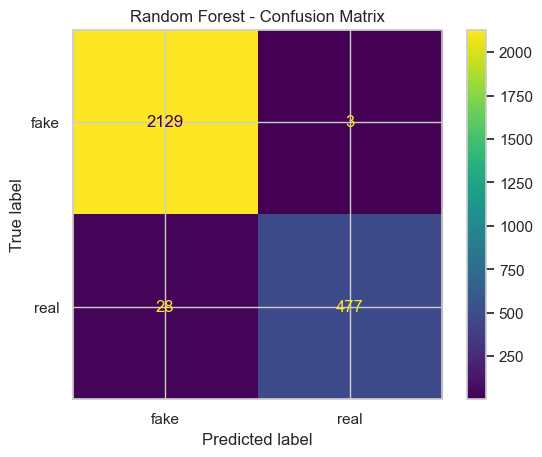

In [35]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_rf, display_labels=le.classes_)
plt.title("Random Forest - Confusion Matrix")
plt.show()

In [36]:
joblib.dump(rf, "models/random_forest.joblib")
print("Saved RF model.")

Saved RF model.


# KNN

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [38]:
knn = KNeighborsClassifier(n_neighbors=7)

In [39]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [40]:
y_pred_knn = knn.predict(X_val)
knn_acc = accuracy_score(y_val, y_pred_knn)

In [41]:
print("KNN Accuracy:", knn_acc)
print(classification_report(y_val, y_pred_knn, target_names=le.classes_))

KNN Accuracy: 0.9829351535836177
              precision    recall  f1-score   support

        fake       0.99      0.99      0.99      2132
        real       0.96      0.95      0.96       505

    accuracy                           0.98      2637
   macro avg       0.97      0.97      0.97      2637
weighted avg       0.98      0.98      0.98      2637



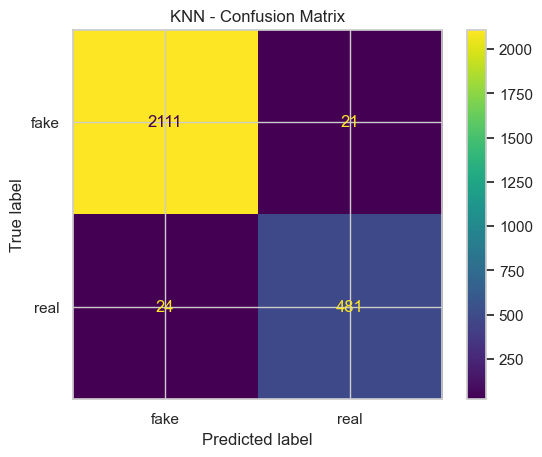

In [42]:
ConfusionMatrixDisplay.from_predictions(y_val, y_pred_knn, display_labels=le.classes_)
plt.title("KNN - Confusion Matrix")
plt.show()

In [43]:
joblib.dump(knn, "models/knn.joblib")
print("Saved knn model.")

Saved knn model.
